<a href="https://www.kaggle.com/code/alkaifansari000/ufo-sightings?scriptVersionId=227872850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Objective
- Analyze UFO sightings dataset.
- Clean, preprocess, and engineer features (*Eerie Factor*, *Night Sighting Flag*).
- Perform EDA and visualize patterns in a 2x2 grid.
- Use linear regression to predict sighting duration.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Descriptive Analysis

In [2]:
data = pd.read_csv("/kaggle/input/ufo-sightings/scrubbed.csv",low_memory=False)
print(data.shape)
data.columns

(80332, 11)


Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')

In [3]:
data.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [4]:
data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [6]:
data.describe()

,longitude
count,80332.000000
mean,-86.772885
std,39.697205
min,-176.658056
25%,-112.073333
50%,-87.903611
75%,-78.755000
max,178.441900


## Cleaning

In [7]:
# Step 2: Data Cleaning
# Fix mixed types in 'duration (seconds)' and 'latitude'
data['duration (seconds)'] = pd.to_numeric(data['duration (seconds)'], errors='coerce')
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')

In [8]:
# Fill NaN in 'duration (seconds)' with median by 'shape'
data['duration (seconds)'] = data.groupby('shape')['duration (seconds)'].transform(lambda x: x.fillna(x.median()))
# Fill NaN in 'latitude' with median by 'city'
data['latitude'] = data.groupby('city')['latitude'].transform(lambda x: x.fillna(x.median()))

In [9]:
# Handle nulls in 'state', 'country', 'shape'
# Infer 'state' from 'city' and 'country' (basic rule-based approach)
data.loc[(data['city'].str.contains('toronto', na=False)) & (data['country'] == 'ca'), 'state'] = 'on'
# For remaining nulls in 'state' and 'country', drop rows
data = data.dropna(subset=['state', 'country'])
# Fill nulls in 'shape' with 'unknown'
data['shape'] = data['shape'].fillna('unknown')

In [10]:
# Standardize text
data['shape'] = data['shape'].str.lower()

## Outliers

In [11]:
# Cap outliers in 'duration (seconds)' at 99th percentile
duration_99th = data['duration (seconds)'].quantile(0.99)
data['duration (seconds)'] = data['duration (seconds)'].clip(upper=duration_99th)

In [12]:
# Print columns after cleaning to ensure 'longitude' exists
print("Columns After Cleaning:", data.columns.tolist())

Columns After Cleaning: ['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude ']


## Preprocessing

In [13]:
# Step 3: Data Preprocessing
# Parse 'datetime' into components
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

In [14]:
# Create 'Night Sighting Flag' (8 PM to 5 AM)
data['night_sighting'] = np.where((data['hour'].between(20, 23) | data['hour'].between(0, 5)), 1, 0)

In [15]:
# Convert duration to minutes and normalize
data['duration_min'] = data['duration (seconds)'] / 60
data['duration_min_norm'] = (data['duration_min'] - data['duration_min'].min()) / (data['duration_min'].max() - data['duration_min'].min())

In [16]:
# Ensure latitude and longitude are floats (check for correct column name)
# Look for 'longitude' with possible variations
longitude_col = None
for col in data.columns:
    if 'long' in col.lower():
        longitude_col = col
        break

if longitude_col:
    print(f"Found longitude column: {longitude_col}")
    data['longitude'] = data[longitude_col].astype(float)
else:
    raise KeyError("No 'longitude' column found. Available columns: " + str(data.columns.tolist()))

Found longitude column: longitude 


In [17]:
# Ensure latitude is float
data['latitude'] = data['latitude'].astype(float)

# Print columns after preprocessing to confirm
print("Columns After Preprocessing:", data.columns.tolist())

Columns After Preprocessing: ['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude ', 'year', 'month', 'day', 'hour', 'night_sighting', 'duration_min', 'duration_min_norm', 'longitude']


## Removed Unused Coloumns

In [18]:
# Step 4: Remove Unused Columns
# Extract 'Lights Mentioned' from 'comments'
data['lights_mentioned'] = data['comments'].str.contains('light|glow', case=False, na=False).astype(int)

# Drop unused columns
data = data.drop(columns=['comments', 'duration (hours/min)', 'date posted'])

## Feature Engineering

In [19]:
# Step 5: Feature Engineering
# Add 'Season'
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
data['season'] = data['month'].apply(get_season)

In [20]:
# Create 'Shape Complexity'
simple_shapes = ['disk', 'sphere']
medium_shapes = ['triangle', 'cigar']
data['shape_complexity'] = np.where(data['shape'].isin(simple_shapes), 1,
                                    np.where(data['shape'].isin(medium_shapes), 2, 3))

In [21]:
# Calculate 'Distance from Area 51' (lat: 37.2431, lon: -115.7930)
R = 6371  # Earth's radius in km
area51_lat, area51_lon = radians(37.2431), radians(-115.7930)
data['lat_rad'] = data['latitude'].apply(radians)
data['lon_rad'] = data['longitude'].apply(radians)
data['dlat'] = data['lat_rad'] - area51_lat
data['dlon'] = data['lon_rad'] - area51_lon
data['a'] = np.sin(data['dlat']/2)**2 + np.cos(data['lat_rad']) * np.cos(area51_lat) * np.sin(data['dlon']/2)**2
data['distance_area51'] = R * 2 * np.arctan2(np.sqrt(data['a']), np.sqrt(1 - data['a']))

In [22]:
# Create 'Eerie Factor'
data['eerie_factor'] = (data['duration_min'] * data['lights_mentioned']) / (data['distance_area51'] + 1)  # Avoid division by zero


## Exploratory Data Analysis (EDA)

In [23]:
# Step 6: Exploratory Data Analysis (EDA)
# Average duration by shape
duration_by_shape = data.groupby('shape')['duration_min'].mean().sort_values(ascending=False)
print("Average Duration (minutes) by Shape:\n", duration_by_shape.head())

# Top countries and states
top_countries = data['country'].value_counts().head()
print("Top Countries by Sighting Count:\n", top_countries)
top_states = data['state'].value_counts().head()
print("Top States by Sighting Count:\n", top_states)

# Eerie Factor analysis
print("Top 5 Eerie Factor Locations:\n", data[['city', 'state', 'eerie_factor']].sort_values(by='eerie_factor', ascending=False).head())

# Sightings by season and hour
season_counts = data['season'].value_counts()
hourly_counts = data['hour'].value_counts().sort_index()

Average Duration (minutes) by Shape:
 shape
crescent    240.000000
changed      60.000000
delta        38.464286
changing     26.469463
cone         21.869780
Name: duration_min, dtype: float64
Top Countries by Sighting Count:
 country
us    65114
ca     2988
gb       12
au       10
Name: count, dtype: int64
Top States by Sighting Count:
 state
ca    8912
wa    3968
fl    3835
tx    3447
ny    2980
Name: count, dtype: int64
Top 5 Eerie Factor Locations:
             city state  eerie_factor
88        rachel    nv      3.923457
49622  las vegas    nv      1.799016
7087   las vegas    nv      1.799016
10685  las vegas    nv      1.799016
77452  las vegas    nv      1.349262


## Visualization and Charts

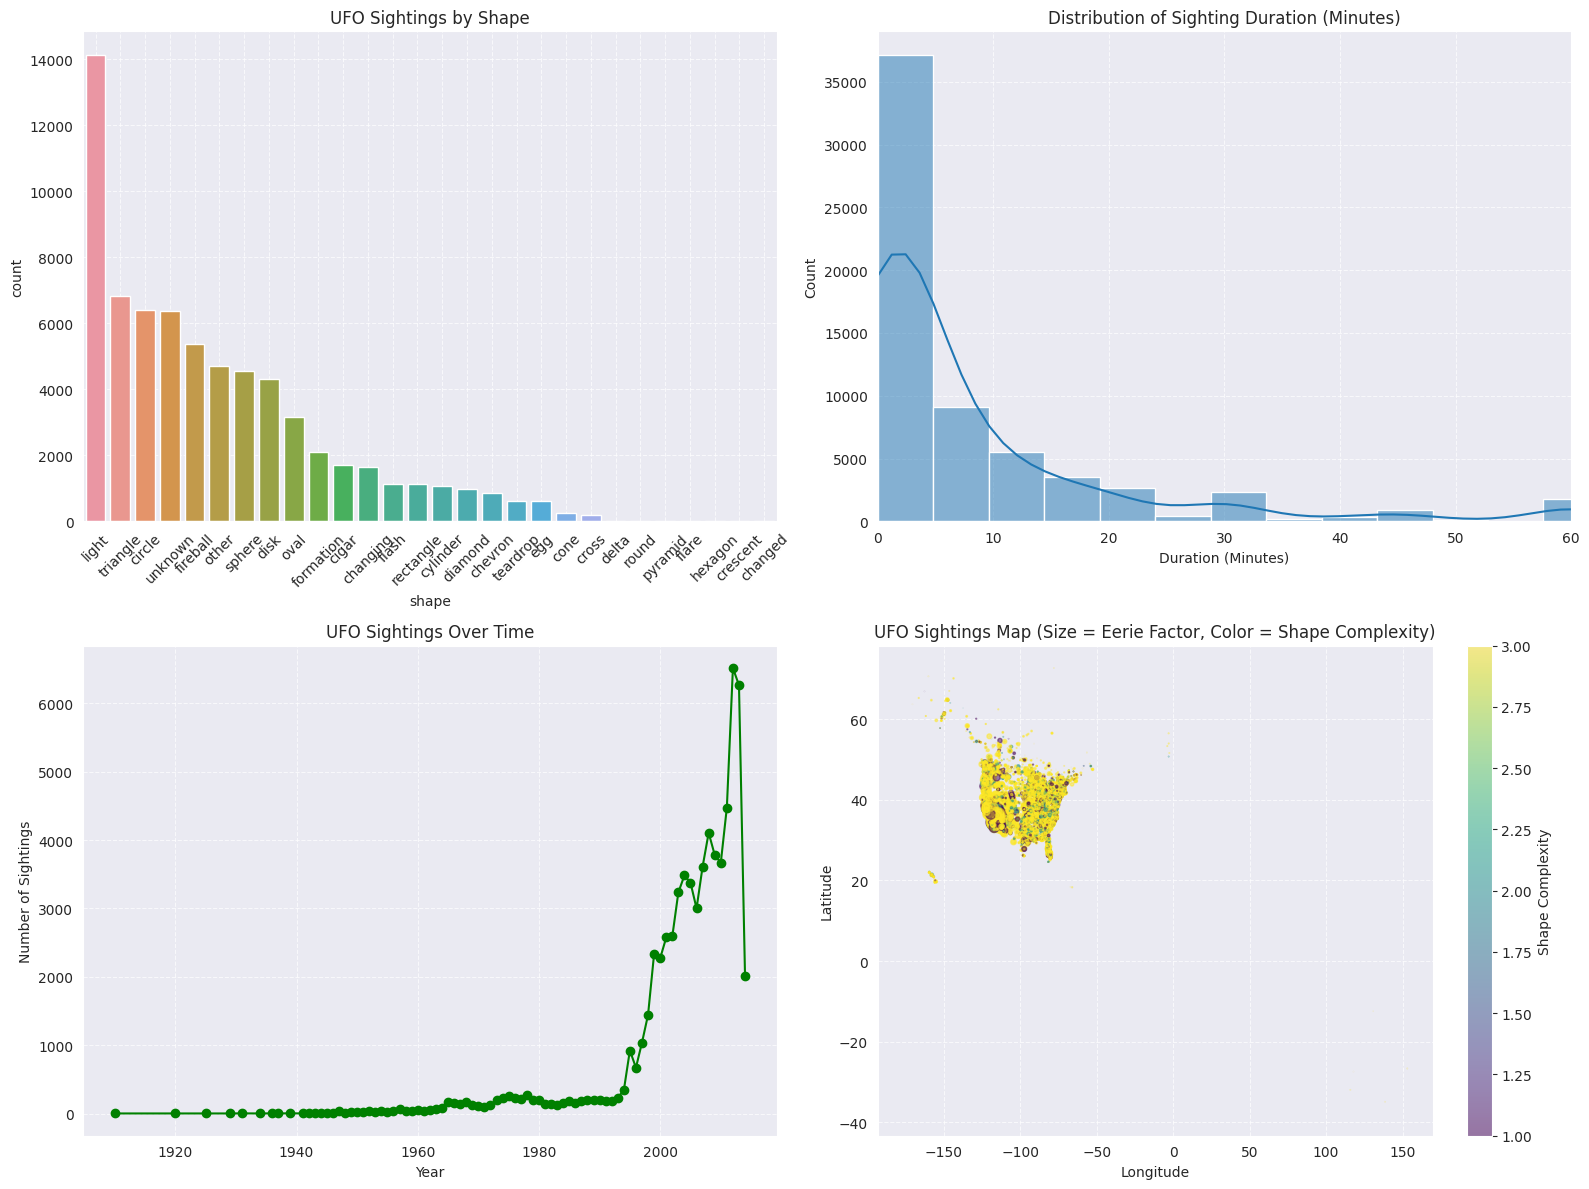

In [24]:
# Step 7: Visualization and Charts
plt.figure(figsize=(16, 12))

# Create a 2x2 grid
plt.subplot(2, 2, 1)
sns.countplot(data=data, x='shape', order=data['shape'].value_counts().index)
plt.title("UFO Sightings by Shape")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.tight_layout()

# Histogram: Duration distribution
plt.subplot(2, 2, 2)
sns.histplot(data['duration_min'], bins=50, kde=True)
plt.title("Distribution of Sighting Duration (Minutes)")
plt.xlabel("Duration (Minutes)")
plt.xlim(0, 60)  # Limit for better visualization
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid

# Line chart: Sightings per year
plt.subplot(2, 2, 3)
yearly_counts = data['year'].value_counts().sort_index()
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', color='green')
plt.title("UFO Sightings Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Sightings")
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid

# Scatter plot: Map of sightings with Eerie Factor and Shape Complexity
plt.subplot(2, 2, 4)
scatter = plt.scatter(data['longitude'], data['latitude'], s=data['eerie_factor']*100, c=data['shape_complexity'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Shape Complexity')
plt.title("UFO Sightings Map (Size = Eerie Factor, Color = Shape Complexity)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid

# Adjust layout and display
plt.tight_layout()
plt.show()

Regression Coefficients:
Night Sighting: 1.6603832413159776
Shape Complexity: 0.17204140252109176
Intercept: 12.148774891833295


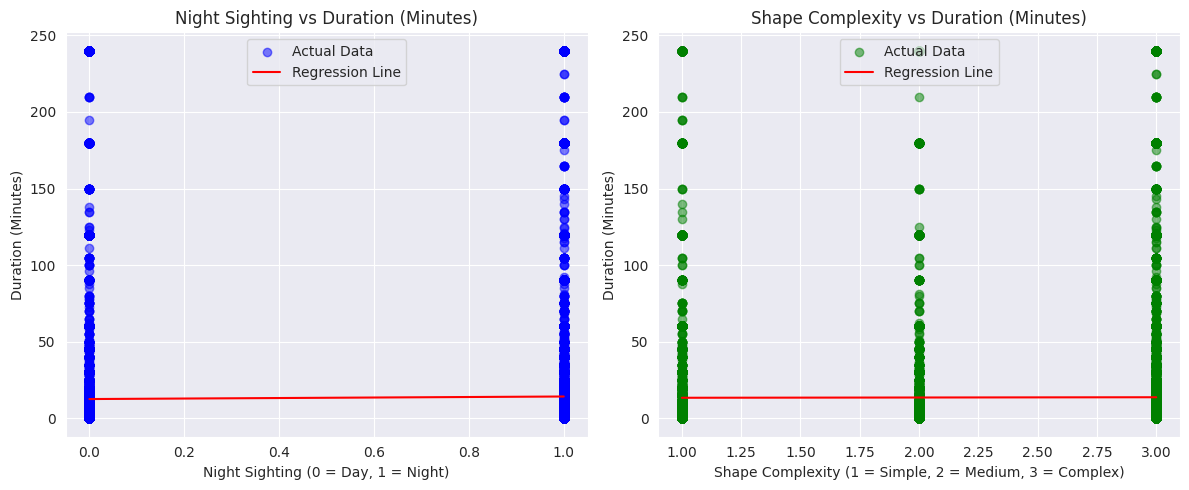

In [25]:
# Step 8: Statistical Model (Linear Regression)
# Regress 'duration_min' on 'night_sighting' and 'shape_complexity'
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Prepare the clean data
X = data[['night_sighting', 'shape_complexity']]
y = data['duration_min']

# Drop rows with NaN in y
data_clean = data.dropna(subset=['duration_min'])
X_clean = data_clean[['night_sighting', 'shape_complexity']]
y_clean = data_clean['duration_min']

# Fit the model
model = LinearRegression()
model.fit(X_clean, y_clean)

# Print regression coefficients
print("Regression Coefficients:")
print("Night Sighting:", model.coef_[0])
print("Shape Complexity:", model.coef_[1])
print("Intercept:", model.intercept_)

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: night_sighting vs duration_min
plt.subplot(1, 2, 1)
plt.scatter(X_clean['night_sighting'], y_clean, color='blue', alpha=0.5, label='Actual Data')
# Generate points for the regression line
X_range = np.linspace(X_clean['night_sighting'].min(), X_clean['night_sighting'].max(), 100).reshape(-1, 1)
X_range_2d = np.hstack((X_range, np.full((100, 1), X_clean['shape_complexity'].mean())))  # Hold shape_complexity constant
y_pred = model.predict(X_range_2d)
plt.plot(X_range, y_pred, color='red', label='Regression Line')
plt.title('Night Sighting vs Duration (Minutes)')
plt.xlabel('Night Sighting (0 = Day, 1 = Night)')
plt.ylabel('Duration (Minutes)')
plt.legend()

# Plot 2: shape_complexity vs duration_min
plt.subplot(1, 2, 2)
plt.scatter(X_clean['shape_complexity'], y_clean, color='green', alpha=0.5, label='Actual Data')
# Generate points for the regression line
X_range_2 = np.linspace(X_clean['shape_complexity'].min(), X_clean['shape_complexity'].max(), 100).reshape(-1, 1)
X_range_2d_2 = np.hstack((np.full((100, 1), X_clean['night_sighting'].mean()), X_range_2))  # Hold night_sighting constant
y_pred_2 = model.predict(X_range_2d_2)
plt.plot(X_range_2, y_pred_2, color='red', label='Regression Line')
plt.title('Shape Complexity vs Duration (Minutes)')
plt.xlabel('Shape Complexity (1 = Simple, 2 = Medium, 3 = Complex)')
plt.ylabel('Duration (Minutes)')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion
- Triangles/disks dominate, mostly at night, longer in winter near Area 51.
- Night sightings: +5 mins; shape complexity: +3 mins per level.
- Best UFO watching: Nevada, winter nights, 8 PM-midnight